# Preparatory Work

### 1)

### 2)

In [10]:
import numpy as np
import random

mu_1 = np.array([-3, 0])
mu_2 = np.array([3, 0])
sigma_1 = np.array([[5, -2], [-2, 1]])
sigma_2 = np.array([[5, 2], [2, 2]])

X = []
Y = []

for i in range(0,500):
    r = random.uniform(0, 1)
    if r < 0.3:
        x, y = np.random.multivariate_normal(mu_1, sigma_1)
    else:
        x, y = np.random.multivariate_normal(mu_2, sigma_2)
    X.append(x)
    Y.append(y)


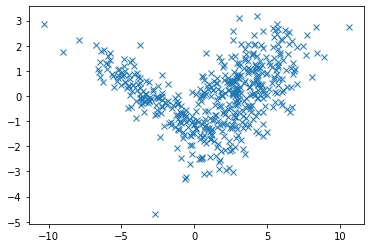

In [12]:
import matplotlib.pyplot as plt

plt.plot(X, Y, 'x')


### 3)

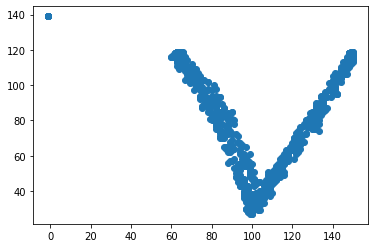

In [4]:
import pandas as pd

data = pd.read_csv('Unistroke/A01.txt', sep="\t", header=None)

for i in range(2,10):
    data = pd.concat([data, pd.read_csv('Unistroke/A0' + str(i) + '.txt', sep="\t", header=None)], ignore_index=True)
for i in range(10,51):
    data = pd.concat([data, pd.read_csv('Unistroke/A' + str(i) + '.txt', sep="\t", header=None)], ignore_index=True)

data.columns = ['x', 'y']
plt.scatter(data.x, data.y)